In [149]:
from collections import defaultdict, namedtuple
from math import ceil
from typing import List, Optional

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle

In [3]:
rng = np.random.default_rng(42)

In [4]:
rng.random(5)

array([0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735])

In [196]:
disk = namedtuple("disk", ["x", "y"])

def get_disks(
    n: int = 10,
    canvas_size: float = 50,
    seed: float = 42,
):
    rng = np.random.default_rng(seed)
    xs = rng.random(n) * canvas_size
    ys = rng.random(n) * canvas_size
    return [disk(x, y) for x, y in zip(xs, ys)]

def disks_overlap(d1: disk, d2: disk) -> bool:
    dist = np.sqrt((d1.x - d2.x) ** 2 + (d1.y - d2.y) ** 2)
    return dist <= 2

def get_cell_idx_pt(
    coord: float,
    cell_width: float,
    offset: float,
):
    return (coord - offset) // cell_width

def contained_in_cell(
    coord: float,
    cell_width: float,
    offset: float,
    radius: float = 1,
):
    low_cell = get_cell_idx_pt(coord - radius, cell_width, offset)
    mid_cell = get_cell_idx_pt(coord, cell_width, offset)
    hi_cell = get_cell_idx_pt(coord + radius, cell_width, offset)
    return low_cell == mid_cell and mid_cell == hi_cell

def get_disk_cell_idx(
    d: disk,
    cell_width: float,
    grid_offset_x: float,
    grid_offset_y: float,
    grid_width: int,
) -> Optional[int]:
    if not contained_in_cell(d.x, cell_width, grid_offset_x):
        return None
    if not contained_in_cell(d.y, cell_width, grid_offset_y):
        return None

    # Disk positions are lower bounded by 0, so lowest grid position is 0.
    # Explicitly add the max here to avoid weird behavior around 0 with
    # the offset.
    x_bin = max(get_cell_idx_pt(d.x, cell_width, grid_offset_x), 0)
    y_bin = max(get_cell_idx_pt(d.y, cell_width, grid_offset_y), 0)

    return int(x_bin + (y_bin * grid_width))

In [197]:
def plot_disks(disks, ax, **kwargs):
    patches = []
    for disk in disks:
        patches.append(Circle([disk.x, disk.y], radius=1))
    p = PatchCollection(patches, alpha=0.4, **kwargs)
    ax.add_collection(p)

In [198]:
canvas_size = 50
k = 12
n = 100
grid_offset_x = rng.random() * k
grid_offset_y = rng.random() * k

In [203]:
test = get_disks(n=n, canvas_size=canvas_size)

In [204]:
num_lines = ceil(canvas_size / k)
vlines = [i*k + grid_offset_x for i in range(0, num_lines)]
hlines = [i*k + grid_offset_y for i in range(0, num_lines)]

In [205]:
contained = []
not_contained = []
binned = defaultdict(list)
for d in test:
    idx = get_disk_cell_idx(d, k, grid_offset_x, grid_offset_y, num_lines+1)
    if idx is None:
        not_contained.append(d)
    else:
        contained.append(d)
        binned[idx].append(d)

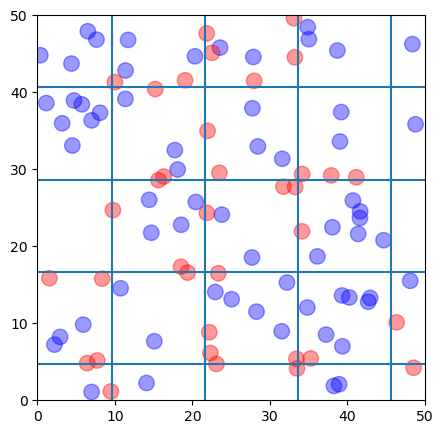

In [202]:

fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
plot_disks(contained, ax, color="blue")
plot_disks(not_contained, ax, color="red")
plt.xlim(0, canvas_size)
plt.ylim(0, canvas_size)

for x,y in zip(vlines, hlines):
    ax.axvline(x=x)
    ax.axhline(y=y)


In [209]:
from itertools import combinations

def is_disjoint_set(disks: List[disk]) -> bool:
    for (i, d1) in enumerate(disks[:-1]):
        for d2 in disks[i+1:]:
            if disks_overlap(d1, d2):
                return False
    return True

def minimal_set_cell(disks: List[disk], k: float) -> List[disk]:
    max_num = int(k**2)
    for num in range(max_num, 0, -1):
        for check_set in combinations(disks, r=num):
            if is_disjoint_set(check_set):
                return check_set
    raise ValueError(f"must be a disjoint set of some size: {disks}")

def compute_approxmate_packed_set(
    disks: List[disk],
    grid_offset_x: float,
    grid_offset_y: float,
    canvas_size: float,
    k: float,

):
    num_lines = ceil(canvas_size / k)

    contained = []
    not_contained = []
    binned = defaultdict(list)
    for d in disks:
        idx = get_disk_cell_idx(d, k, grid_offset_x, grid_offset_y, num_lines+1)
        if idx is None:
            not_contained.append(d)
        else:
            contained.append(d)
            binned[idx].append(d)

    min_disks = []
    for bin_idx, bin_disks in binned.items():
        bin_min_set = minimal_set_cell(bin_disks, k)
        print(f"{bin_idx}: {len(bin_min_set)}")
        min_disks.extend(bin_min_set)
    print(f"min set size: {len(min_disks)}")
    return min_disks


In [210]:
min_disks = compute_approxmate_packed_set(
    test,
    grid_offset_x,
    grid_offset_y,
    canvas_size,
    k,
)

20: 2
2: 6
12: 8
15: 1
8: 6
6: 4
1: 5
18: 6
13: 3
0: 6
21: 1
7: 2
14: 2
19: 2
3: 1
min set size: 55


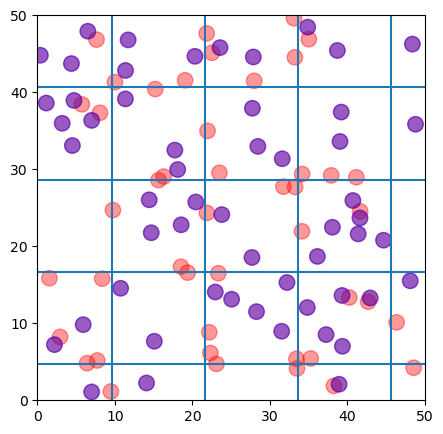

In [211]:
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
plot_disks(test, ax, color="red")
plot_disks(min_disks, ax, color="blue")
plt.xlim(0, canvas_size)
plt.ylim(0, canvas_size)

for x,y in zip(vlines, hlines):
    ax.axvline(x=x)
    ax.axhline(y=y)


In [162]:
is_disjoint_set(binned[2][:1])

True

In [165]:
is_disjoint_set(next(combinations(binned[2], r=1)))

True

In [174]:
got = minimal_set_cell(binned[2], k=k)

In [180]:
got

(disk(x=42.929895995569126, y=13.293498072975979),
 disk(x=39.30321526384769, y=13.612078092257951),
 disk(x=37.23810779539086, y=8.529648426844306),
 disk(x=39.34621887510692, y=7.012454449930539),
 disk(x=34.8160187538868, y=12.048528750284238))

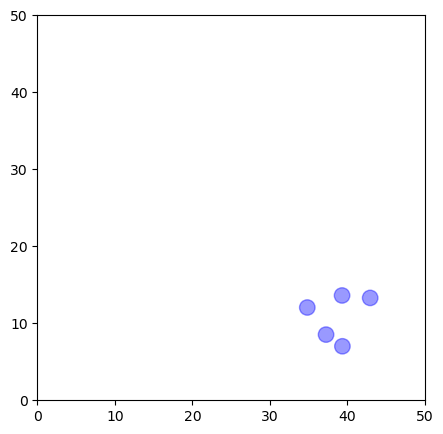

In [183]:
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()

plot_disks(got, ax, color="blue")
plt.xlim(0, canvas_size)
plt.ylim(0, canvas_size)
plt.show()